# Reana-SPL Data Analysis

This repository contains execution data and analysis for persistent variations of the [Reana-SPL](https://github.com/SPLMC/reana-spl) tool.

# SPL Analysis Approach

Reana-SPL performs a product-line reliability analysis on a variety of software-product-lines.

To leverage the commonality among different products in order to speed up analysis,
we use a [feature-family-based analysis](https://www.infosun.fim.uni-passau.de/publications/docs/LCA+17ist.pdf). Instead of enumerating products and analyzing
them one-by-one (product-based analysis), we analyze features in isolation
and exploit the commonality among products to get results for the entire
product space more efficiently.

We analyze the data of three approaches to handling the evolved models.
- Non-evolution-aware: The analysis tool does not do any
  special handling of evolved models (`reana`)
- Evolution-aware without reordering: The analysis tool handles evolved models
  by reusing ADDs generated in previous runs.
  ADDs are only automatically reordered in the first run (`reanaEord`).
- Evolution-aware with reordering: Same as the above, but ADDs are reordered
  automatically at each iteration (`reanaE`).

We expect the non-evolution-aware analysis to perform the worst, with
both evolution-aware approaches obtaining similar results.
There is a tradeoff to ADD reordering: while it is expensive, it obtains
smaller ADDs on which operations are easier to perform.

# Data 

The data used contains runtime information for different variations of the
[Reana-SPL](https://github.com/SPLMC/reana-spl) product line analysis tool.
Different approaches are implemented in different branches of the main repository.
The main difference in the implementations is in the handling of ADD persistence.
The non-evolution-aware does not save its generated ADDs nor does it read ADDs
from previous executions, as is done in the evolution-aware implementations.

We execute an evolution scenario on the initial models of 6 different product
lines (BSN, Email, IC, Lift, MP, TW).
Each evolution doubles the amount of products to be analyzed.
Each model is evolved in a fixed manner up to 22 times, so we have an
increase in the product space of up to \(2^21\)-fold


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as iter
from tabulate import tabulate
from scipy.stats import *
from functools import reduce
from IPython.display import display, Markdown
from math import sqrt
from pprint import pprint

In [22]:
def cohens_d(s1, s2):
    assert(len(s1) == len(s2))
    N = len(s1)

    if N < 50:
        factor = ((N-3)/(N-2.25)) * sqrt((N-2)/N)
    else:
        factor = 1

    s = factor * sqrt((np.std(s1, ddof=1)**2 + np.std(s2, ddof=1)**2) / 2)
    cohens_d = (np.mean(s1) - np.mean(s2)) / s
    return cohens_d

# Reading Data

In [23]:
def out_to_csv(in_filename, out_filename):
    data = []
    i = -1
    with open(in_filename) as in_f:
        lines = in_f.readlines()
    for line in lines:
        if not isNumber(line):
            i += 1
            data.append([])
        else:
            data[i].append(float(line))
    with open(out_filename, 'w') as out_f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                if j == len(data[i])-1:
                    out_f.write("{}\n".format(data[i][j]))
                else:
                    out_f.write("{},".format(data[i][j]))
        
    
def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def concat(lists):
    return list(iter.chain.from_iterable(lists))

In [24]:
def _read_data(spl, filenames, labels, factor=1.0):
    dfs = []
    for filename in filenames:
        df = pd.read_csv(filename, header=None).transpose()
        dfs.append(df)

    # delete extra rows (to match sample sizes)
    n = min([df.shape[0] for df in dfs])
    for df in dfs:
        if df.shape[0] > n:
            rows = list(range(n, df.shape[0]))
            df = df.drop(rows, inplace=True) 
        
    df = pd.concat(dfs, keys=labels)
    df *= factor
    
    return df, n

def read_data(spl, filenames, labels, factor=1.0):
    df, n = _read_data(spl, filenames, labels, factor=factor)
    df['Label'] = np.repeat(labels, np.repeat([n], len(labels)), axis=0)
    return df

# Plotting Graphs

In [25]:
def make_line_graph(df, spl, labels, title=None, yscale='linear', xlabel='x', ylabel='y', filename=None):

    means = []
    stds = []

    for label in labels:
        dfl = df.loc[label]
        means.append(np.mean(dfl))
        stds.append(np.std(dfl))
    
    df_mean = pd.concat(means, keys=labels)
    df_std = pd.concat(stds, keys=labels)
    
    plt.figure(figsize=(12,5)) # TODO: is this OK?
    
    axs = []

    for i in range(len(labels)):
        label = labels[i]
        if i == 0:
            ax = df_mean[label].plot(grid=True, yerr=df_std[label], label=label)
        else:
            ax = df_mean[label].plot(grid=True, secondary_y=False, yerr=df_std[label], label=label)

        axs.append(ax)

    xticks = np.arange(0, df_mean[labels[0]].shape[0], 1)

    for ax in axs:
        ax.set_xticks(xticks)
    
    # plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend()
    plt.yscale(yscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is None:
        plt.title(spl)
    else:
        plt.title(title)
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

In [26]:
def make_box_plot(df, spl, title=None, xlabel='', ylabel='', filename=None):
    means = np.mean(df)
    stdevs = np.std(df)
    fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
    
    # these magics work for 5 by 5 plots, which is appropriate for our current data dimensions
    i = 4
    j = 4
    while i * 5 + j + 1 > len(means):
        fig.delaxes(ax_new[i, j])
        if j == 0:
            j = 4
            i -= 1
        else:
            j -= 1

    bp = df.boxplot(by="Label",ax=ax_new.flatten()[:len(means)], figsize=(6,8))

    for i in range(len(means)):
        ax_new.flatten()[i].autoscale()
        ax_new.flatten()[i].set_xlabel(xlabel)
        ax_new.flatten()[i].set_ylabel(ylabel)
    
    if title is None:
        title = spl

    fig.suptitle(title)
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

In [27]:
def get_means_df(df, labels):
    dfs = [np.mean(df.loc[label]) for label in labels]
    return pd.concat(dfs, keys=labels)

# Statistical Testing

In [28]:
def is_normally_distributed(samples, significance=0.01):
    x, p = normaltest(samples)
    return p >= significance

def compare_samples(s1, s2, significance=0.01):
    d = cohens_d(s1, s2)
    if s1.equals(s2):
        return {'result': 'eq', 'method': 'all-equal', 'd': d}
    if (is_normally_distributed(s1, significance=significance)
        and is_normally_distributed(s2, significance=significance)):
        # both normally distributed
        v1, p1 = bartlett(s1, s2)                                 # test variances
        equal_var= p1 >= significance
        
        v2, p2 = ttest_ind(s1, s2, equal_var=equal_var)  # equal variances is assumed unless stated otherwise
        
        method = 'T-test' if equal_var else 'Welch'      # from ttest_ind's documentation
        eq = p2 >= significance
        diff = np.mean(s1) - np.mean(s2)
        r = "eq" if eq else 'gt' if diff > 0 else 'lt'
        
        return {'result': r, 'method': method, 'p1': p1, 'v1': v1, 'p2': p2, 'v2': v2, 'd': d}
    else:
        # not both normally distributed
        u, p = mannwhitneyu(s1, s2, use_continuity=False)
        eq = p >= significance
        diff = np.mean(s1) - np.mean(s2)
        r = 'eq' if eq else 'gt' if diff > 0 else 'lt'
        d = cohens_d(s1, s2) # not sure if can use d test when not normally distributed
        return {'result': r, 'method': 'Mann-Whitney', 'u': u, 'p2': p, 'd': d}

In [29]:
def test_all_evolutions_pairs(df, labels):
    pairs = list(iter.combinations(labels, 2))
    return [(t1, t2, test_all_evolutions(df, t1, t2)) for (t1, t2) in pairs]

def test_all_evolutions(df, t1, t2):
    n = get_num_evolutions(df)
    return [test(df, i, t1, t2) for i in range(n)]

def test(df, i, t1, t2):
    s1 = get_evolution_samples(df, i, label=t1)
    s2 = get_evolution_samples(df, i, label=t2)
    if s1 is None or s2 is None:
        # one of the samples contains NaN
        return None
    else:
        return compare_samples(s1, s2)

def print_test_results(t1, t2, comparison, verbose=False):
    if verbose:
        print('{}\t{}'.format(i, comparison))
    else:
        if comparison is None:
            print('No samples')
        elif result['result'] == 'eq':
            print('{} == {}'.format(t1, t2))
        elif result['result'] == 'lt':
            print('{} > {}'.format(t1, t2))
        elif result['result'] == 'gt':
            print('{} < {}'.format(t1, t2))

def get_num_evolutions(df):
    label = df['Label'][0]
    return df.loc[label].shape[1] - 1  # exclude type column

def get_evolution_samples(df, n, label):
    s = df.iloc[:][n].loc[label]
    if s.isnull().any():  # check if any sample is NaN
        return None
    else:
        return s

In [30]:
def test_min(ordering):
    '''
    ordering has format
    [(x, y, compare(x,y)), (x, z, compare(x,z)), (y, z, compare(y,z))]
    returns the smallest element or None if there is no such element.
    
    Example: [(x, y, 'eq'), (x, z, 'gt'), (y, z, 'gt')] => z
    '''
    candidates = get_valid_labels(ordering)
    for (t1, t2, c) in ordering:
        if c == 'eq':
            if t1 in candidates: candidates.remove(t1)
            if t2 in candidates: candidates.remove(t2)
        elif c == 'lt':
            if t2 in candidates: candidates.remove(t2)
        elif c == 'gt':
            if t1 in candidates: candidates.remove(t1)
    if len(candidates) == 1:
        return candidates[0]
    else:
        return None
        
def get_orderings(tests):
    orderings = (
        list(
            zip(*[
                [
                    (t1, t2, t['result'] if t else None, t['d'] if t else None) for t in ts
                ]
                for (t1, t2, ts) in tests]
            )
        )
    )
    return orderings

def get_valid_labels(ordering):
    elements = []
    for element in ordering:
        if element[2] is not None:
            elements.append(element[0:2])
    return list(set(concat(elements)))


In [31]:
def get_table(df, labels, title=None, items_per_row=0, bolded=None):
    # generating lines and headers/separators
    lines = {}
    mdf = get_means_df(df, labels)
    n = get_num_evolutions(df)
    r = ((n // items_per_row) + 1) * items_per_row
    for label in labels:
        lines[label] = get_lines_for_label(mdf, label, n, items_per_row, bolded)

    header = format_row([' Type '] + [' ' + str(i) + ' ' for i in range(items_per_row)])
    first_separator = format_row(['---' for i in range(items_per_row + 1)])
    last_separator  = format_row(['---' for i in range(items_per_row + 1)])
    separator = (
        lambda k :
            format_row([' --- '] + [' ' + (str(i) if i < n else '---') + ' ' for i in range(items_per_row * k, items_per_row * (k + 1) )])
    )
    separators = [first_separator] + [separator(i) for i in range(1, r // items_per_row)] + [last_separator]    

    # writing to buffer
    buffer = ''
    if title:
        buffer += '| {} |\n'.format(str(title))
    buffer += header + '\n'

    flag = True
    i = 0
    while flag:
        buffer += separators[i] + '\n'
        for label in labels:
            if not lines[label]:
                flag = False
                break
            line = lines[label].pop(0)
            buffer += line + '\n'
        i += 1
    return buffer
    
def get_lines_for_label(mdf, label, n, m=0, mins=None):
    '''
    mdf: dataframe containing averages
    label: label for which table lines are generated
    n: number of total elements for each label in mdf
    m: number of elements per row
    mins: label to be bolded for each item
    '''
    lines = []
    r = ((n // m) + 1) * m
    s = '| {} '.format(label)
    for i in range(r):
        if i < n:
            x = mdf.loc[label].iloc[i]
            value = '--' if isnan(x) else '{x:.2f}'.format(x=x)
            if i < n and mins is not None and mins[i] == label:
                s += '| **{}** '.format(value)
            else:
                s += '| {} '.format(value)
        else:
            value = '--'
            s += '| {} '.format(value)

        if m != 0 and i != 0 and i != (r-1) and (i+1) % m == 0:
            lines.append(s + '|')
            s = '| {} '.format(label)

    lines.append(s + '|')
    return lines

def isnan(x):
    return x is float('nan') or x == 'nan' or x == np.nan or np.isnan(x)

def format_row(items):
    return reduce(
        lambda a, b: a + b,
        ['|{}'.format(x) for x in items] + ['|']
    )

# Running and Displaying Results

In [32]:
# This cells converts .out files to .csv
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']
labels = ['Reana', 'ReanaE', 'ReanaEord']

rt_data = concat([['running_time/totalTime{}{}'.format(spl, label) for spl in spls] for label in labels])
mem_data = concat([['memory_usage/totalMemory{}{}'.format(spl, label) for spl in spls] for label in labels])

for filename in rt_data:
    out_to_csv('data/{}.out'.format(filename), 'csv/{}.csv'.format(filename))

for filename in mem_data:
        out_to_csv('data/{}.out'.format(filename), 'csv/{}.csv'.format(filename))

In [33]:
def plot_spl(spl):
    def process(filenames, labels, title, header=None, xlabel='Evolution', ylabel='', yscale='log', factor=1.0, table_suffix='', table_description=None):
        if header:
            display(Markdown('## {}'.format(header)))
        df = read_data(spl, filenames, labels, factor=factor)

        make_line_graph(df, spl, labels, title=title, xlabel=xlabel, ylabel=ylabel, yscale='log')   

        test_results = test_all_evolutions_pairs(df, labels)

        make_box_plot(df, spl, title=title)

        orderings = get_orderings(test_results)

        # mins = [test_min(ordering) for ordering in orderings]
        mins = [test_min([(t1, t2, c) for (t1, t2, c, _) in ordering]) for ordering in orderings]

        n = get_num_evolutions(df)

        items_per_row = min(n, 10)

        if table_description:
            display(Markdown(table_description))
        table = get_table(df, labels, title=None, items_per_row=items_per_row, bolded=mins)
        
        pprint(list(
            zip(
                range(len(orderings)),
                orderings
            )
        ))

        display(Markdown(table))

        with open('tables/{}{}.md'.format(spl, table_suffix), 'w') as f:
            f.write(table)

    display(Markdown('# {}'.format(spl)))
    rt_labels = ['Reana', 'ReanaE', 'ReanaEord']
    rt_filenames = ['csv/running_time/totalTime{}{}.csv'.format(spl, label) for label in rt_labels]
    process(rt_filenames, rt_labels, '{}: Running Time'.format(spl), header='Running Time',
        ylabel='Running Time (s)', factor=1.0/1000.0, table_suffix='rt',
        table_description="Average running time (s) (statistically smallest value in bold)")

    mem_labels = ['Reana', 'ReanaE', 'ReanaEord']
    mem_filenames = ['csv/memory_usage/totalMemory{}{}.csv'.format(spl, label) for label in mem_labels]
    process(mem_filenames, mem_labels, '{}: Memory Usage'.format(spl), header='Memory Usage',
        ylabel='Memory Usage (MB)', table_suffix='mem',
        table_description="Average memory usage (MB) (statistically smallest value in bold)")

# BSN

## Running Time

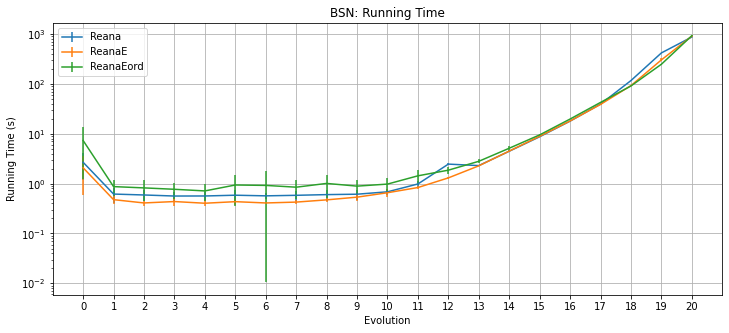

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


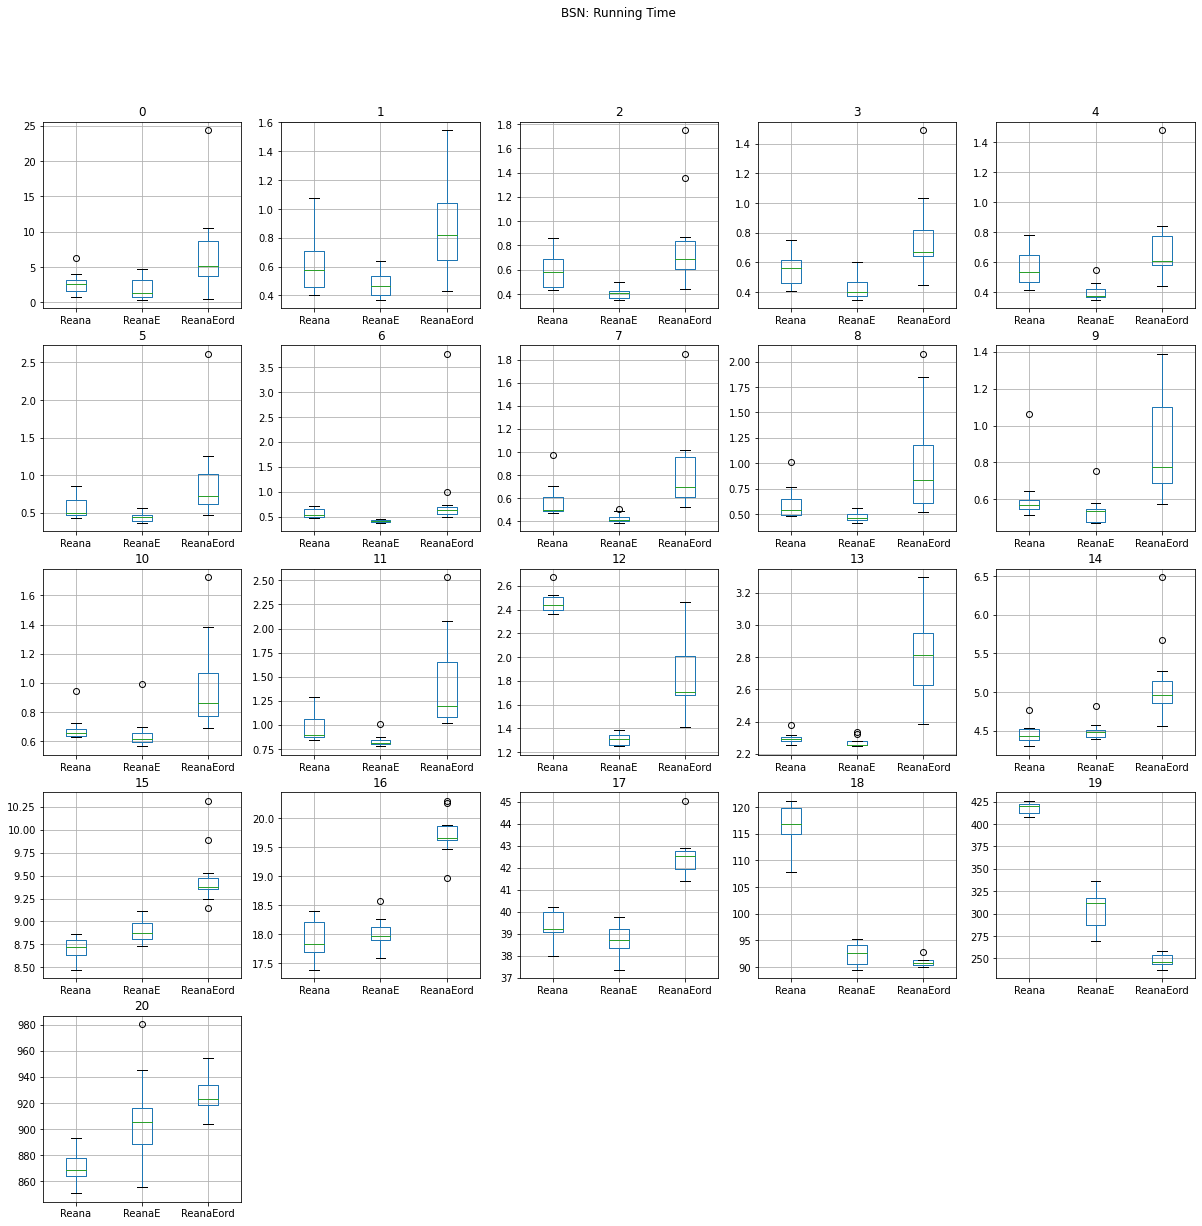

Average running time (s) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'eq', 0.46070675184066695),
   ('Reana', 'ReanaEord', 'lt', -1.208021167268052),
   ('ReanaE', 'ReanaEord', 'lt', -1.3663853262726509))),
 (1,
  (('Reana', 'ReanaE', 'eq', 1.058133421763285),
   ('Reana', 'ReanaEord', 'eq', -1.1315532362099927),
   ('ReanaE', 'ReanaEord', 'lt', -2.0314919087498953))),
 (2,
  (('Reana', 'ReanaE', 'gt', 2.0311444741496394),
   ('Reana', 'ReanaEord', 'eq', -0.9369778902846176),
   ('ReanaE', 'ReanaEord', 'lt', -1.7788154965310983))),
 (3,
  (('Reana', 'ReanaE', 'gt', 1.5163868402036051),
   ('Reana', 'ReanaEord', 'lt', -1.1208996716873834),
   ('ReanaE', 'ReanaEord', 'lt', -1.8836604336397051))),
 (4,
  (('Reana', 'ReanaE', 'gt', 2.0554543877586173),
   ('Reana', 'ReanaEord', 'eq', -0.8323258496400013),
   ('ReanaE', 'ReanaEord', 'lt', -1.8506108414073879))),
 (5,
  (('Reana', 'ReanaE', 'eq', 1.5385106816772776),
   ('Reana', 'ReanaEord', 'eq', -0.9638010287387899),
   ('ReanaE', 'ReanaEord', 'lt', -1.416018408937062))),
 (6,
 

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 2.68 | 0.62 | 0.59 | 0.56 | 0.57 | 0.59 | 0.57 | 0.58 | 0.60 | 0.61 |
| ReanaE | 2.08 | 0.48 | **0.41** | **0.44** | **0.40** | 0.43 | **0.41** | **0.43** | **0.47** | 0.54 |
| ReanaEord | 7.31 | 0.87 | 0.82 | 0.77 | 0.71 | 0.94 | 0.92 | 0.85 | 1.01 | 0.89 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 0.68 | 0.98 | 2.46 | 2.30 | 4.46 | **8.70** | 17.91 | 39.32 | 116.67 | 418.06 |
| ReanaE | 0.66 | **0.83** | **1.30** | 2.27 | 4.49 | 8.89 | 18.02 | 38.74 | 92.39 | 302.94 |
| ReanaEord | 0.98 | 1.43 | 1.86 | 2.80 | 5.12 | 9.49 | 19.73 | 42.52 | 90.89 | **247.68** |
| --- | 20 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | **871.06** | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 906.22 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | 925.86 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

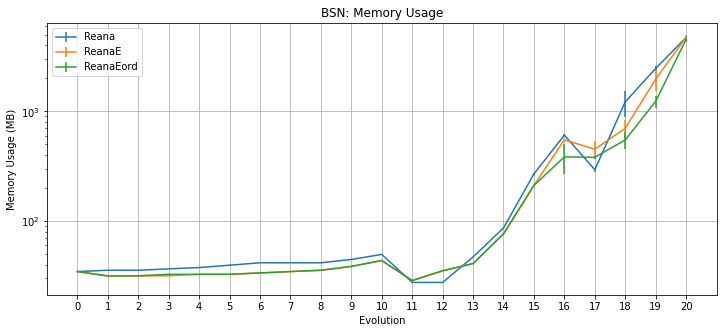

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-22-38f230941c8c>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
<ipython-input-22-38f230941c8c>:11: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


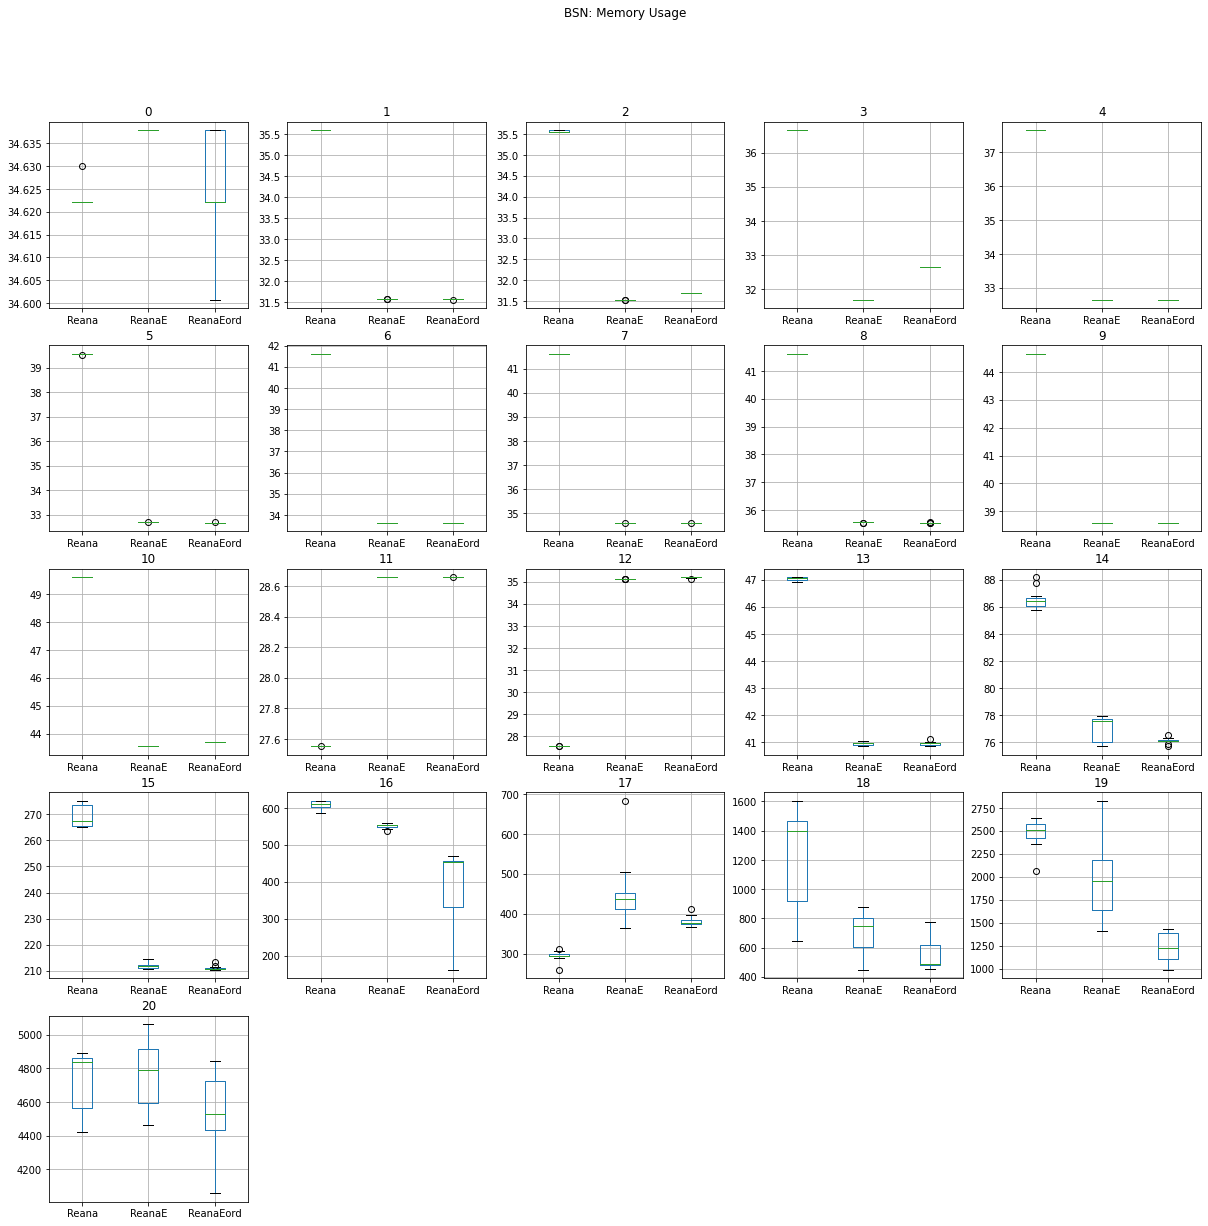

Average memory usage (MB) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'lt', -10.827572586919478),
   ('Reana', 'ReanaEord', 'eq', -0.44562309514521964),
   ('ReanaE', 'ReanaEord', 'gt', 1.7942965523611525))),
 (1,
  (('Reana', 'ReanaE', 'gt', 169571.94802453666),
   ('Reana', 'ReanaEord', 'gt', 2918.7651335138944),
   ('ReanaE', 'ReanaEord', 'gt', 0.5389660380832405))),
 (2,
  (('Reana', 'ReanaE', 'gt', 309.53343976304063),
   ('Reana', 'ReanaEord', 'gt', 297.44400174814547),
   ('ReanaE', 'ReanaEord', 'lt', -774.0837932101949))),
 (3,
  (('Reana', 'ReanaE', 'gt', inf),
   ('Reana', 'ReanaEord', 'gt', inf),
   ('ReanaE', 'ReanaEord', 'lt', -inf))),
 (4,
  (('Reana', 'ReanaE', 'gt', inf),
   ('Reana', 'ReanaEord', 'gt', inf),
   ('ReanaE', 'ReanaEord', 'eq', nan))),
 (5,
  (('Reana', 'ReanaE', 'gt', 1041.978769489992),
   ('Reana', 'ReanaEord', 'gt', 922.4351049172392),
   ('ReanaE', 'ReanaEord', 'gt', 5.021034455368458))),
 (6,
  (('Reana', 'ReanaE', 'gt', inf),
   ('Reana', 'ReanaEord', 'gt', inf),
   ('ReanaE', 'ReanaEord', 

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 34.62 | 35.59 | 35.56 | 36.66 | 37.64 | 39.57 | 41.62 | 41.62 | 41.62 | 44.66 |
| ReanaE | 34.64 | 31.57 | **31.54** | **31.70** | 32.66 | 32.68 | **33.62** | 34.61 | 35.56 | 38.58 |
| ReanaEord | 34.63 | **31.57** | 31.70 | 32.66 | 32.66 | **32.66** | 33.64 | 34.61 | **35.54** | 38.58 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 49.62 | **27.55** | **27.54** | 47.04 | 86.57 | 269.47 | 608.17 | **294.40** | 1224.18 | 2469.70 |
| ReanaE | **43.54** | 28.66 | 35.13 | 40.94 | 76.91 | 212.00 | 550.91 | 452.25 | 702.83 | 1974.24 |
| ReanaEord | 43.70 | 28.66 | 35.20 | 40.96 | 76.11 | 211.13 | **385.17** | 381.59 | **549.77** | **1236.79** |
| --- | 20 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | 4735.15 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 4759.33 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | 4557.51 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


In [34]:
plot_spl('BSN')

# Email

## Running Time

/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


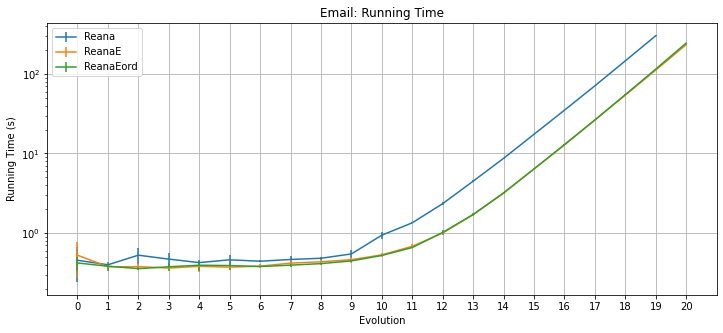

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


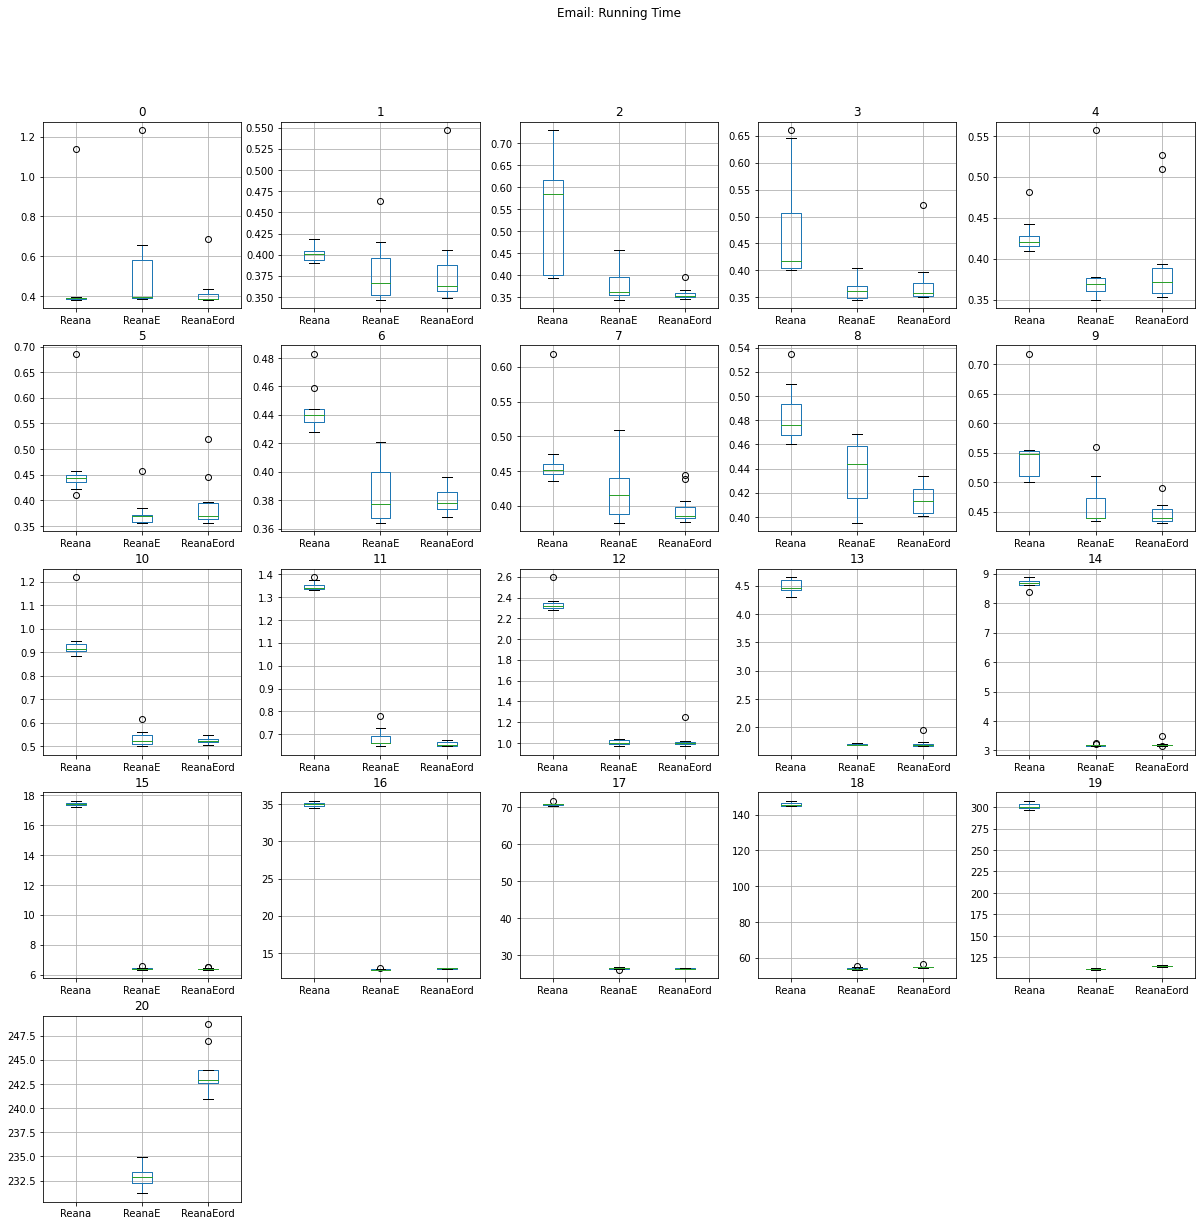

Average running time (s) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'eq', -0.3569994720620569),
   ('Reana', 'ReanaEord', 'eq', 0.24332854903466083),
   ('ReanaE', 'ReanaEord', 'eq', 0.6689212035982527))),
 (1,
  (('Reana', 'ReanaE', 'eq', 1.0053420959379722),
   ('Reana', 'ReanaEord', 'eq', 0.4752247383290986),
   ('ReanaE', 'ReanaEord', 'eq', -0.14468292238081135))),
 (2,
  (('Reana', 'ReanaE', 'gt', 1.9995289561785625),
   ('Reana', 'ReanaEord', 'gt', 2.38016028143012),
   ('ReanaE', 'ReanaEord', 'eq', 0.8628906877638947))),
 (3,
  (('Reana', 'ReanaE', 'gt', 1.7834015553752394),
   ('Reana', 'ReanaEord', 'gt', 1.4181104514776355),
   ('ReanaE', 'ReanaEord', 'eq', -0.4427334427702551))),
 (4,
  (('Reana', 'ReanaE', 'gt', 1.1870695896637269),
   ('Reana', 'ReanaEord', 'gt', 0.8080757264901501),
   ('ReanaE', 'ReanaEord', 'eq', -0.23864880070511377))),
 (5,
  (('Reana', 'ReanaE', 'gt', 1.8611031192422118),
   ('Reana', 'ReanaEord', 'gt', 1.333824672893782),
   ('ReanaE', 'ReanaEord', 'eq', -0.5175517612404673))),
 (6,
  (('R

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 0.46 | 0.40 | 0.53 | 0.47 | 0.43 | 0.46 | 0.44 | 0.47 | 0.48 | 0.55 |
| ReanaE | 0.53 | 0.38 | 0.38 | 0.36 | 0.38 | 0.37 | 0.38 | 0.42 | 0.44 | 0.46 |
| ReanaEord | 0.42 | 0.38 | 0.36 | 0.38 | 0.40 | 0.39 | 0.38 | 0.40 | 0.41 | 0.45 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 0.94 | 1.35 | 2.35 | 4.49 | 8.69 | 17.44 | 34.97 | 70.78 | 145.80 | 301.25 |
| ReanaE | 0.53 | 0.68 | 1.00 | 1.70 | 3.17 | 6.41 | **12.79** | 26.46 | **54.06** | **111.61** |
| ReanaEord | 0.52 | 0.66 | 1.02 | 1.72 | 3.20 | 6.39 | 12.94 | 26.33 | 54.87 | 114.84 |
| --- | 20 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | **232.93** | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | 243.80 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


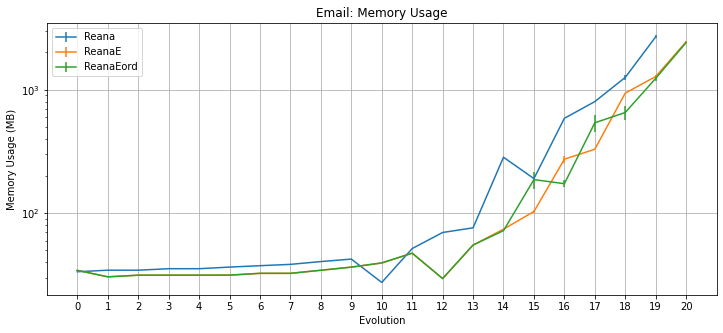

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-22-38f230941c8c>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
<ipython-input-22-38f230941c8c>:11: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


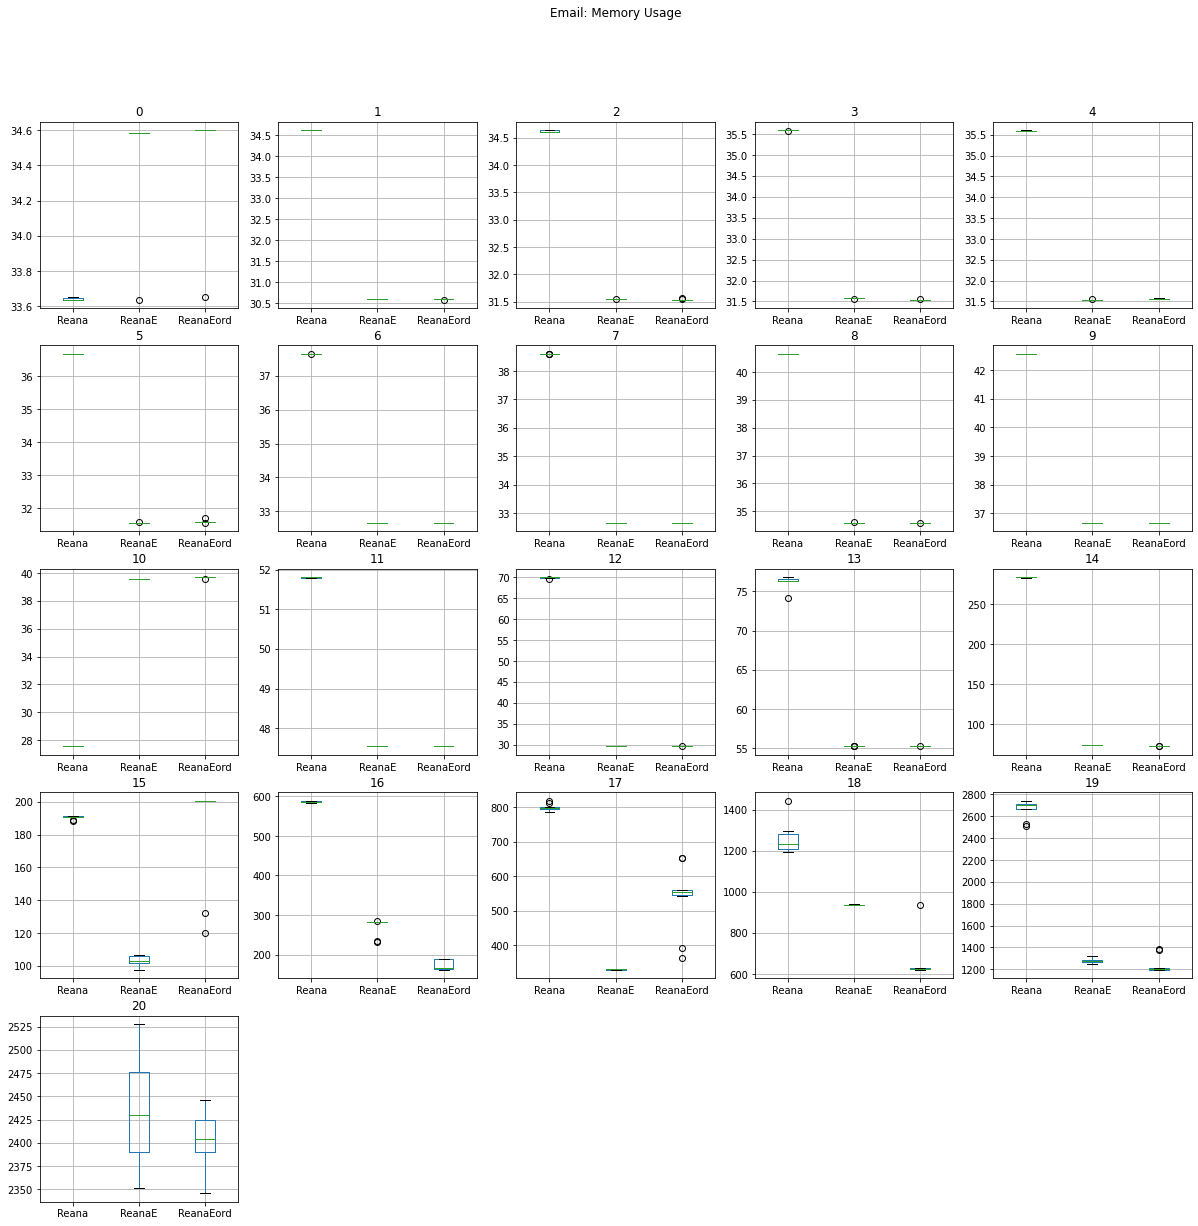

Average memory usage (MB) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'lt', -5.128787601487484),
   ('Reana', 'ReanaEord', 'lt', -5.222344384697623),
   ('ReanaE', 'ReanaEord', 'lt', -0.06617624787981609))),
 (1,
  (('Reana', 'ReanaE', 'gt', 4923.456219864406),
   ('Reana', 'ReanaEord', 'gt', 3560.5011549279748),
   ('ReanaE', 'ReanaEord', 'eq', 0.38502864310782636))),
 (2,
  (('Reana', 'ReanaE', 'gt', 319.83658558063826),
   ('Reana', 'ReanaEord', 'gt', 298.0723041927622),
   ('ReanaE', 'ReanaEord', 'gt', 3.03787036812322))),
 (3,
  (('Reana', 'ReanaE', 'gt', 709.57085967815),
   ('Reana', 'ReanaEord', 'gt', 905.8140608599206),
   ('ReanaE', 'ReanaEord', 'gt', 4.8602824475268145))),
 (4,
  (('Reana', 'ReanaE', 'gt', 670.186642103846),
   ('Reana', 'ReanaEord', 'gt', 683.8766937719364),
   ('ReanaE', 'ReanaEord', 'lt', -5.350612401701607))),
 (5,
  (('Reana', 'ReanaE', 'gt', 1779.222826657715),
   ('Reana', 'ReanaEord', 'gt', 249.43187832661326),
   ('ReanaE', 'ReanaEord', 'lt', -1.9530744248512322))),
 (6,
  (('Reana', 'Reana

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | **33.64** | 34.62 | 34.62 | 35.59 | 35.59 | 36.69 | 37.65 | 38.59 | 40.66 | 42.58 |
| ReanaE | 34.50 | 30.59 | 31.55 | 31.58 | **31.55** | **31.55** | 32.66 | 32.66 | **34.58** | 36.66 |
| ReanaEord | 34.51 | 30.59 | **31.54** | **31.55** | 31.57 | 31.59 | 32.66 | 32.66 | 34.58 | 36.66 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | **27.56** | 51.80 | 69.88 | 76.21 | 283.83 | 190.64 | 586.04 | 799.88 | 1255.33 | 2671.88 |
| ReanaE | 39.54 | 47.54 | 29.62 | **55.26** | 74.33 | **103.25** | 273.62 | **329.31** | 936.61 | 1276.06 |
| ReanaEord | 39.68 | 47.54 | **29.62** | 55.31 | **72.33** | 187.16 | **173.39** | 539.05 | **653.15** | **1232.79** |
| --- | 20 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 2435.88 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | 2402.97 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


In [35]:
plot_spl('Email')

# IC

## Running Time

/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


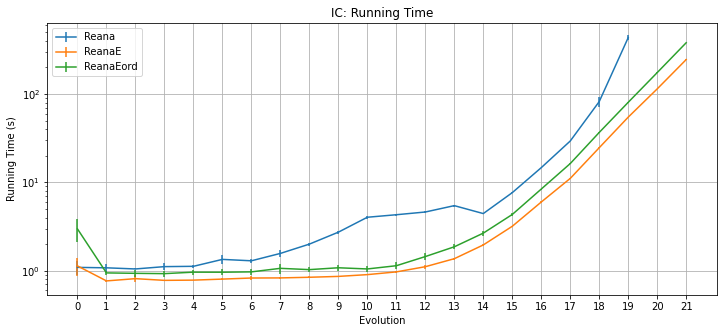

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


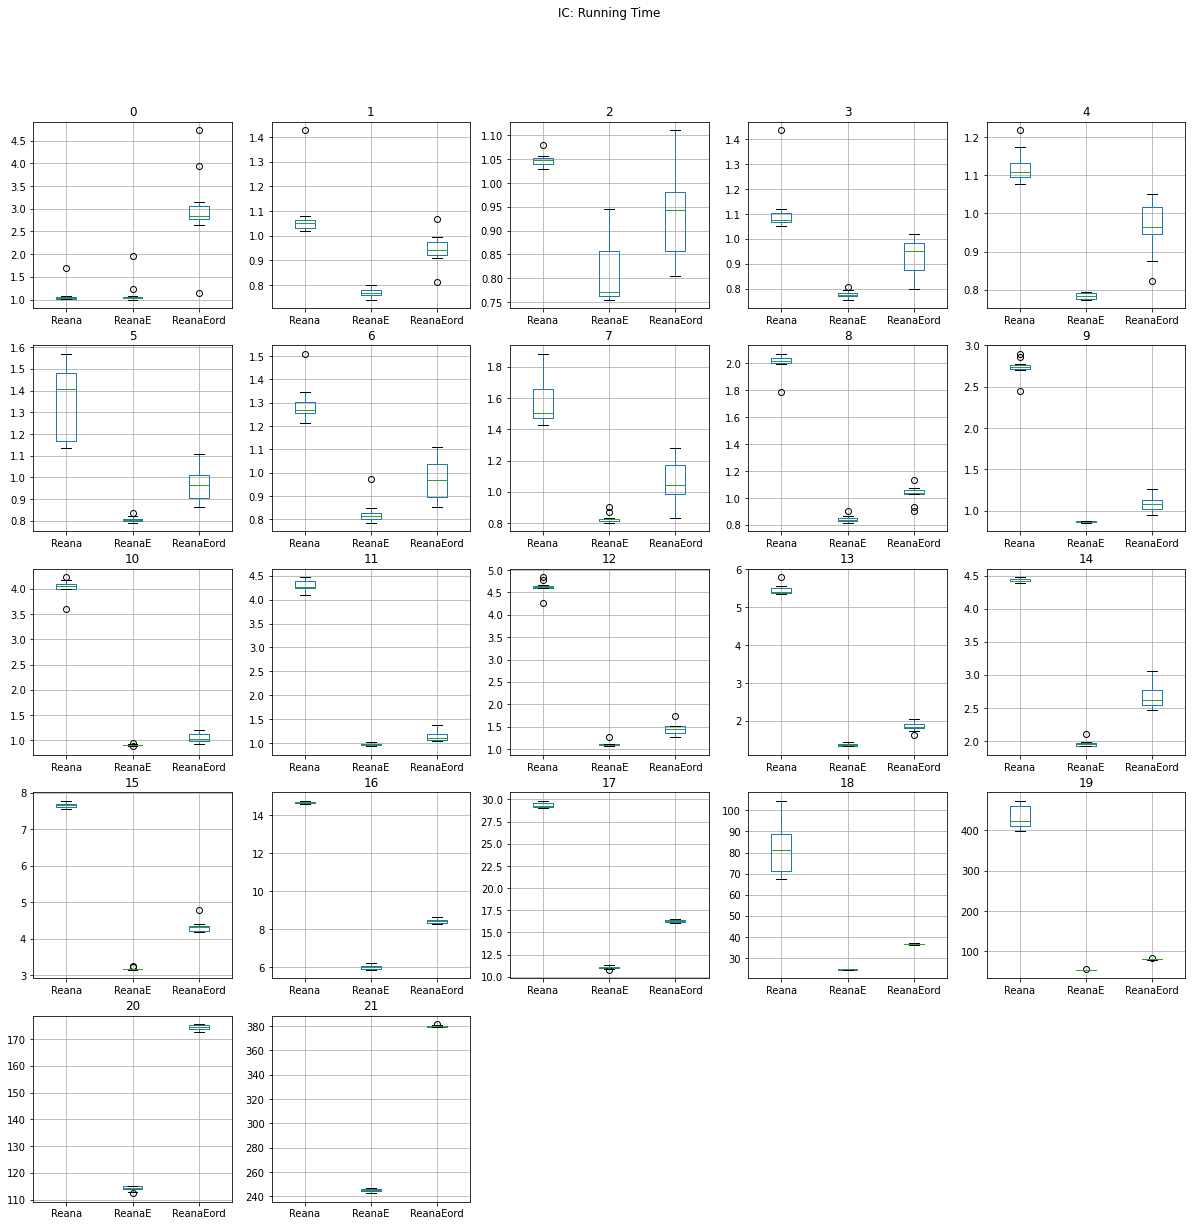

Average running time (s) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'eq', -0.20956295639714945),
   ('Reana', 'ReanaEord', 'lt', -3.5888941458312345),
   ('ReanaE', 'ReanaEord', 'lt', -3.4299877641941445))),
 (1,
  (('Reana', 'ReanaE', 'gt', 4.528408213768642),
   ('Reana', 'ReanaEord', 'gt', 1.7344735624249417),
   ('ReanaE', 'ReanaEord', 'lt', -4.695189830823875))),
 (2,
  (('Reana', 'ReanaE', 'gt', 4.925235501525693),
   ('Reana', 'ReanaEord', 'gt', 1.9817451285634513),
   ('ReanaE', 'ReanaEord', 'lt', -1.6513177781971058))),
 (3,
  (('Reana', 'ReanaE', 'gt', 5.237965210711186),
   ('Reana', 'ReanaEord', 'gt', 2.416971270133493),
   ('ReanaE', 'ReanaEord', 'lt', -3.364736813505549))),
 (4,
  (('Reana', 'ReanaE', 'gt', 13.408133599229163),
   ('Reana', 'ReanaEord', 'gt', 3.3530598136274334),
   ('ReanaE', 'ReanaEord', 'lt', -4.466862737154974))),
 (5,
  (('Reana', 'ReanaE', 'gt', 5.260012149509787),
   ('Reana', 'ReanaEord', 'gt', 3.424902468563754),
   ('ReanaE', 'ReanaEord', 'lt', -3.499555607171934))),
 (6,
  (('Reana',

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 1.09 | 1.08 | 1.05 | 1.11 | 1.12 | 1.34 | 1.30 | 1.57 | 2.00 | 2.73 |
| ReanaE | 1.13 | **0.77** | **0.81** | **0.78** | **0.78** | **0.80** | **0.83** | **0.83** | **0.84** | **0.86** |
| ReanaEord | 2.97 | 0.95 | 0.94 | 0.93 | 0.96 | 0.96 | 0.97 | 1.07 | 1.03 | 1.08 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 4.03 | 4.30 | 4.62 | 5.45 | 4.44 | 7.65 | 14.67 | 29.37 | 82.03 | 434.12 |
| ReanaE | **0.90** | **0.97** | **1.11** | **1.37** | **1.96** | **3.19** | **5.99** | **11.08** | **24.66** | **54.69** |
| ReanaEord | 1.05 | 1.14 | 1.45 | 1.87 | 2.66 | 4.33 | 8.40 | 16.32 | 36.71 | 80.48 |
| --- | 20 | 21 | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | **114.18** | **245.04** | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | 174.50 | 379.95 | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


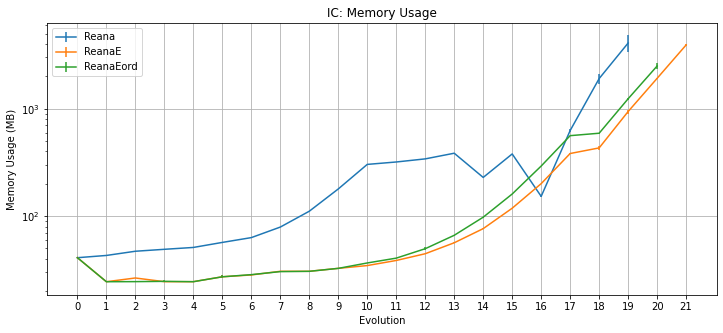

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


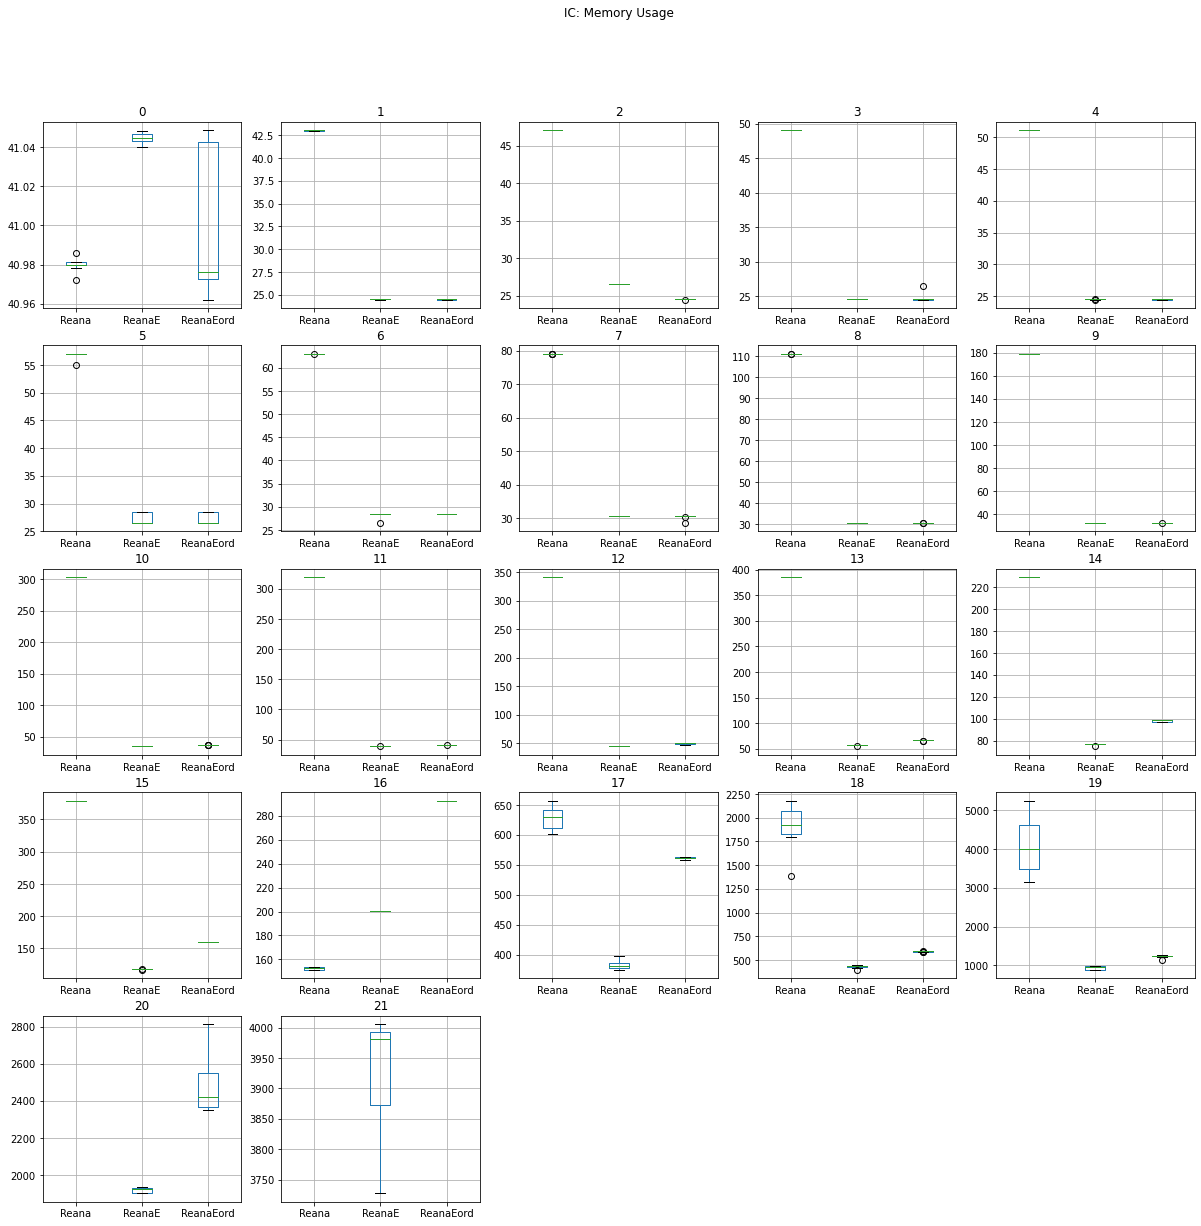

Average memory usage (MB) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'lt', -26.36159070814907),
   ('Reana', 'ReanaEord', 'eq', -1.0510889047207073),
   ('ReanaE', 'ReanaEord', 'gt', 1.941944911717994))),
 (1,
  (('Reana', 'ReanaE', 'gt', 857.6712998068288),
   ('Reana', 'ReanaEord', 'gt', 857.0722219954746),
   ('ReanaE', 'ReanaEord', 'eq', 0.6702612484860407))),
 (2,
  (('Reana', 'ReanaE', 'gt', 6801.050041344512),
   ('Reana', 'ReanaEord', 'gt', 1752.1211326393557),
   ('ReanaE', 'ReanaEord', 'gt', 154.35613757054676))),
 (3,
  (('Reana', 'ReanaE', 'gt', 8059.228781204007),
   ('Reana', 'ReanaEord', 'gt', 69.39537216879833),
   ('ReanaE', 'ReanaEord', 'lt', -0.49158501270362287))),
 (4,
  (('Reana', 'ReanaE', 'gt', 6681.274969273994),
   ('Reana', 'ReanaEord', 'gt', 7274.9426934527955),
   ('ReanaE', 'ReanaEord', 'eq', 1.0214781470958407))),
 (5,
  (('Reana', 'ReanaE', 'gt', 42.882606736304794),
   ('Reana', 'ReanaEord', 'gt', 43.12699646974324),
   ('ReanaE', 'ReanaEord', 'eq', 0.009481957504797673))),
 (6,
  (('Reana', '

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 40.98 | 43.01 | 47.07 | 49.07 | 51.06 | 56.88 | 63.05 | 79.05 | 111.05 | 179.04 |
| ReanaE | 41.04 | 24.49 | 26.53 | **24.51** | 24.51 | 27.22 | 28.31 | 30.62 | 30.62 | 32.62 |
| ReanaEord | 41.00 | 24.49 | **24.53** | 24.68 | 24.50 | 27.21 | 28.50 | 30.42 | **30.60** | 32.61 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 303.09 | 319.18 | 341.18 | 385.17 | 229.20 | 379.19 | **152.72** | 626.79 | 1909.54 | 4092.06 |
| ReanaE | **34.62** | **38.62** | **44.62** | **56.44** | **76.44** | **118.44** | 200.62 | **382.81** | **431.67** | **941.86** |
| ReanaEord | 36.61 | 40.61 | 49.71 | 66.26 | 97.70 | 160.62 | 292.62 | 561.35 | 591.37 | 1238.97 |
| --- | 20 | 21 | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | **1919.33** | 3924.79 | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | 2500.06 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


In [36]:
plot_spl('IC')

# Lift

## Running Time

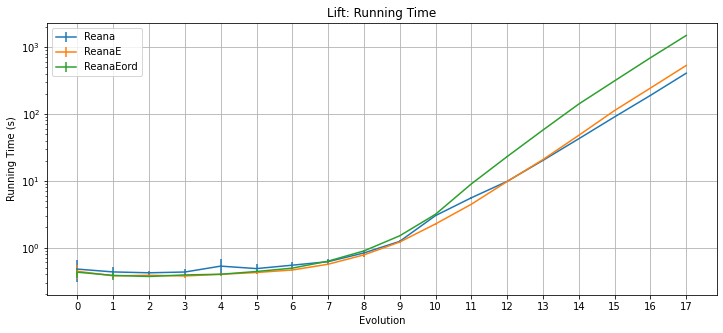

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


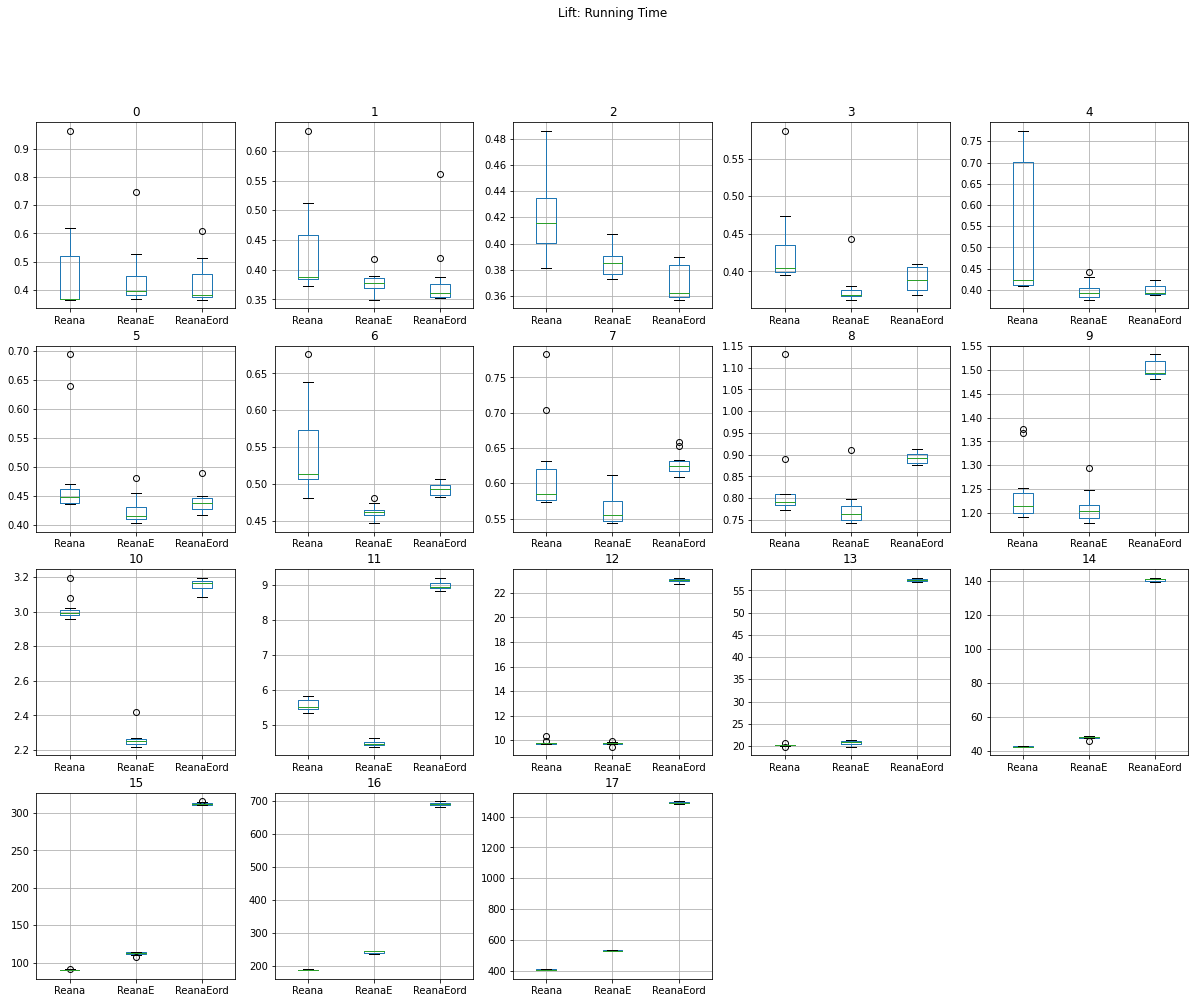

Average running time (s) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'eq', 0.2728134835743251),
   ('Reana', 'ReanaEord', 'eq', 0.41420521953277056),
   ('ReanaE', 'ReanaEord', 'eq', 0.17836883484889235))),
 (1,
  (('Reana', 'ReanaE', 'eq', 1.1320448447641098),
   ('Reana', 'ReanaEord', 'gt', 0.8172507167052637),
   ('ReanaE', 'ReanaEord', 'eq', -0.15844038910893904))),
 (2,
  (('Reana', 'ReanaE', 'gt', 1.8043402149353265),
   ('Reana', 'ReanaEord', 'gt', 2.526910563972008),
   ('ReanaE', 'ReanaEord', 'gt', 1.5330716047514126))),
 (3,
  (('Reana', 'ReanaE', 'gt', 1.5343274694894595),
   ('Reana', 'ReanaEord', 'eq', 1.19119930224351),
   ('ReanaE', 'ReanaEord', 'lt', -0.8387467894518744))),
 (4,
  (('Reana', 'ReanaE', 'eq', 1.3902064928736737),
   ('Reana', 'ReanaEord', 'eq', 1.3905565568818896),
   ('ReanaE', 'ReanaEord', 'eq', -0.04994262950473695))),
 (5,
  (('Reana', 'ReanaE', 'gt', 1.1113552552090673),
   ('Reana', 'ReanaEord', 'eq', 0.8494494318012273),
   ('ReanaE', 'ReanaEord', 'eq', -0.8035775912162587))),
 (6,
  (('R

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 0.48 | 0.43 | 0.42 | 0.43 | 0.53 | 0.49 | 0.55 | 0.62 | 0.83 | 1.24 |
| ReanaE | 0.44 | 0.38 | 0.39 | **0.38** | 0.40 | 0.42 | **0.46** | **0.56** | **0.78** | 1.21 |
| ReanaEord | 0.43 | 0.38 | **0.37** | 0.39 | 0.40 | 0.44 | 0.49 | 0.63 | 0.89 | 1.50 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | --- | --- |
| Reana | 3.02 | 5.56 | 9.80 | **20.18** | **42.52** | **90.31** | **189.06** | **406.35** | -- | -- |
| ReanaE | **2.26** | **4.46** | 9.74 | 20.76 | 47.83 | 112.42 | 243.52 | 530.43 | -- | -- |
| ReanaEord | 3.16 | 8.98 | 23.01 | 57.40 | 140.57 | 312.35 | 691.13 | 1490.64 | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

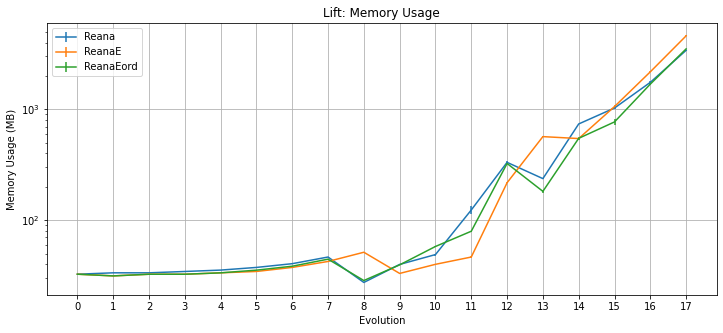

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-22-38f230941c8c>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
<ipython-input-22-38f230941c8c>:11: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


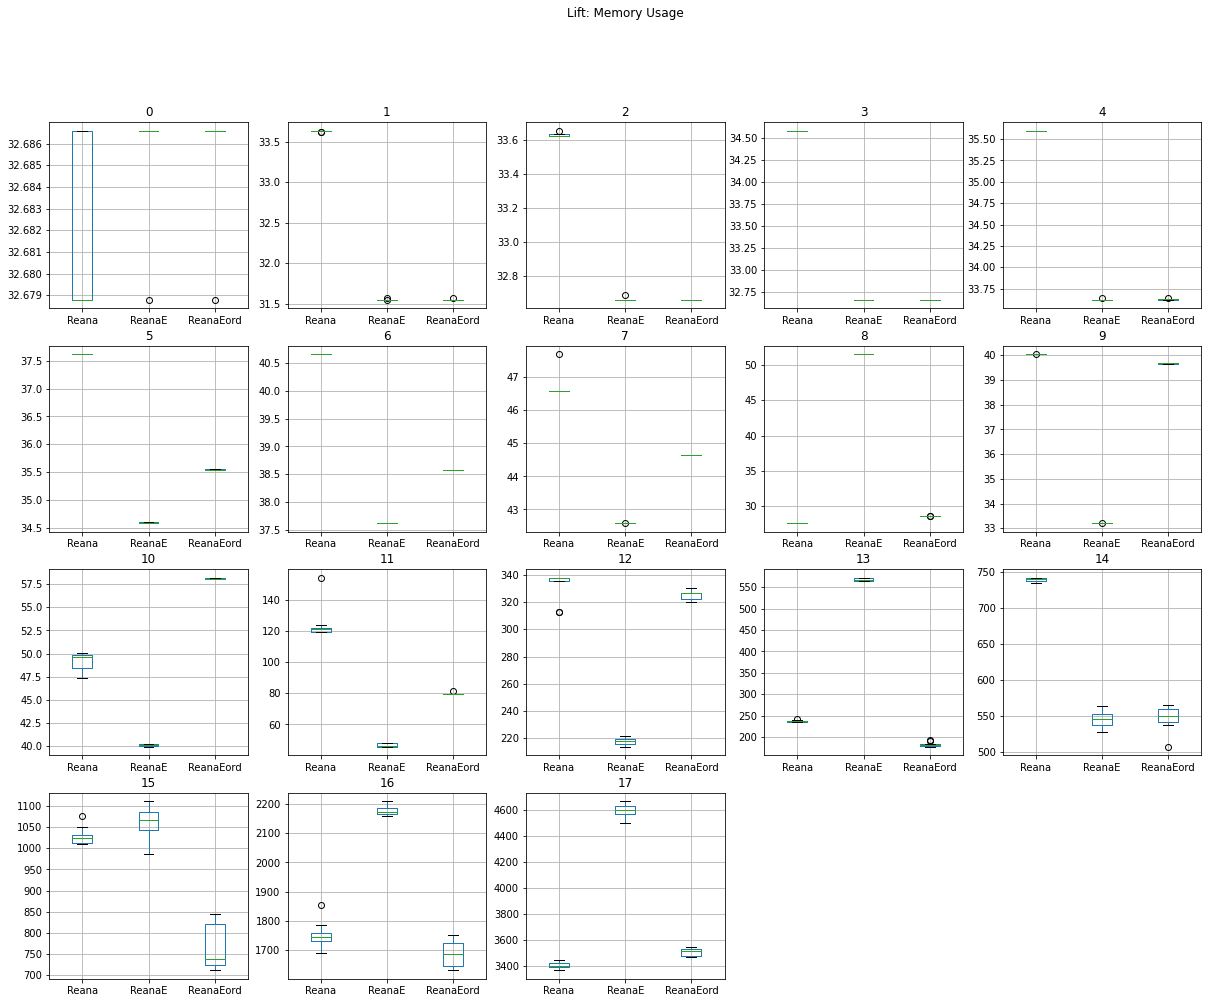

Average memory usage (MB) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'lt', -1.5869792971168533),
   ('Reana', 'ReanaEord', 'lt', -1.5869792971168533),
   ('ReanaE', 'ReanaEord', 'eq', 0.0))),
 (1,
  (('Reana', 'ReanaE', 'gt', 336.66888707735734),
   ('Reana', 'ReanaEord', 'gt', 337.18138780178055),
   ('ReanaE', 'ReanaEord', 'eq', -0.01121024263418117))),
 (2,
  (('Reana', 'ReanaE', 'gt', 133.62858723962276),
   ('Reana', 'ReanaEord', 'gt', 190.282860636222),
   ('ReanaE', 'ReanaEord', 'eq', 0.5155986946156917))),
 (3,
  (('Reana', 'ReanaE', 'gt', 63250.95941472498),
   ('Reana', 'ReanaEord', 'gt', 63250.95941472498),
   ('ReanaE', 'ReanaEord', 'eq', nan))),
 (4,
  (('Reana', 'ReanaE', 'gt', 454.14134302975094),
   ('Reana', 'ReanaEord', 'gt', 448.3161070403817),
   ('ReanaE', 'ReanaEord', 'lt', -0.6566664386715743))),
 (5,
  (('Reana', 'ReanaE', 'gt', 611.6762429970016),
   ('Reana', 'ReanaEord', 'gt', 486.1375844747158),
   ('ReanaE', 'ReanaEord', 'lt', -146.87758953600868))),
 (6,
  (('Reana', 'ReanaE', 'gt', inf),
   ('Re

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | **32.68** | 33.64 | 33.63 | 34.59 | 35.59 | 37.62 | 40.66 | 46.68 | **27.54** | 40.03 |
| ReanaE | 32.69 | 31.55 | 32.66 | 32.66 | **33.62** | **34.59** | **37.62** | **42.58** | 51.54 | **33.21** |
| ReanaEord | 32.69 | 31.55 | 32.66 | 32.66 | 33.62 | 35.55 | 38.58 | 44.66 | 28.66 | 39.67 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | --- | --- |
| Reana | 49.12 | 123.89 | 332.89 | 237.52 | 738.34 | 1027.70 | 1750.24 | **3402.24** | -- | -- |
| ReanaE | **40.12** | **46.67** | **218.00** | 567.72 | 545.41 | 1059.15 | 2177.51 | 4594.06 | -- | -- |
| ReanaEord | 58.10 | 79.71 | 325.14 | **182.33** | 547.89 | **770.06** | **1687.51** | 3505.33 | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


In [37]:
plot_spl('Lift')

# MP

## Running Time

/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


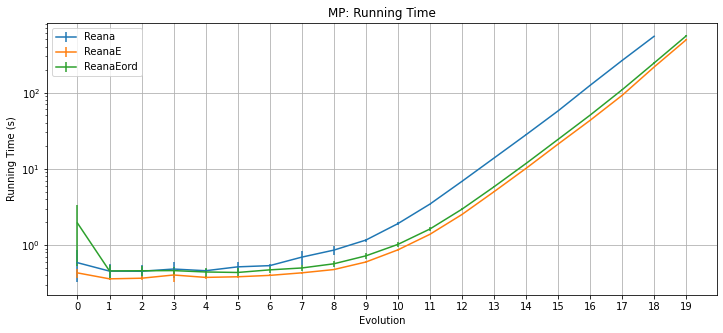

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


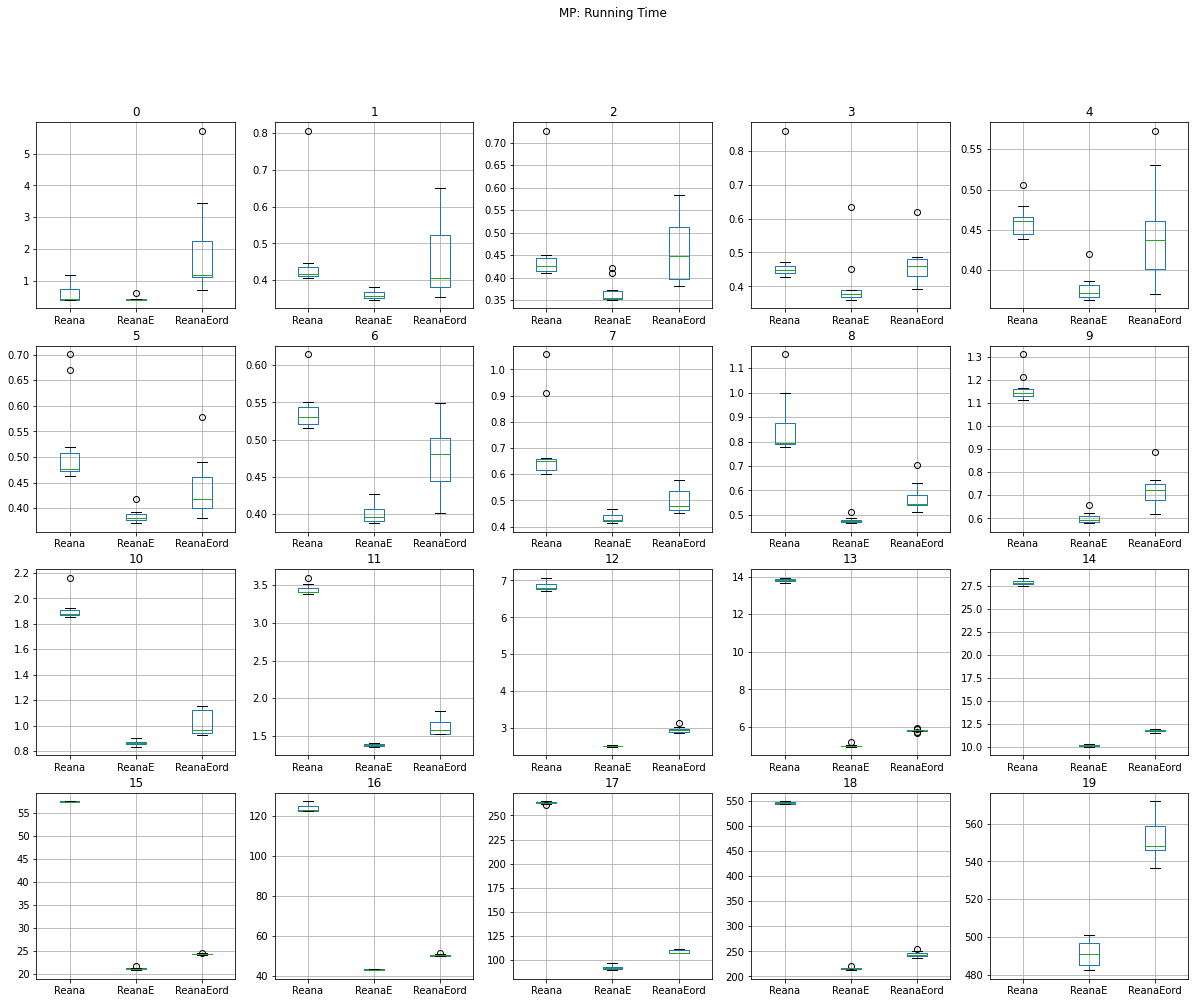

Average running time (s) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'eq', 0.9387969118567309),
   ('Reana', 'ReanaEord', 'lt', -1.5408125365107286),
   ('ReanaE', 'ReanaEord', 'lt', -1.7461796083806875))),
 (1,
  (('Reana', 'ReanaE', 'gt', 1.3769051456140429),
   ('Reana', 'ReanaEord', 'eq', -0.026240929472795486),
   ('ReanaE', 'ReanaEord', 'lt', -1.6513479254246597))),
 (2,
  (('Reana', 'ReanaE', 'gt', 1.541747481837973),
   ('Reana', 'ReanaEord', 'eq', -0.10282727586654829),
   ('ReanaE', 'ReanaEord', 'lt', -1.9800583938955416))),
 (3,
  (('Reana', 'ReanaE', 'gt', 0.9247726483332721),
   ('Reana', 'ReanaEord', 'eq', 0.2764574473343583),
   ('ReanaE', 'ReanaEord', 'lt', -0.9879973476395699))),
 (4,
  (('Reana', 'ReanaE', 'gt', 5.667131841330843),
   ('Reana', 'ReanaEord', 'eq', 0.4518187685330111),
   ('ReanaE', 'ReanaEord', 'lt', -1.7959630232101562))),
 (5,
  (('Reana', 'ReanaE', 'gt', 2.6814433688293646),
   ('Reana', 'ReanaEord', 'eq', 1.338755372040767),
   ('ReanaE', 'ReanaEord', 'lt', -1.505708679438139))),
 (6,
  (

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 0.59 | 0.46 | 0.45 | 0.49 | 0.46 | 0.52 | 0.54 | 0.69 | 0.86 | 1.16 |
| ReanaE | 0.43 | **0.36** | **0.37** | **0.41** | **0.38** | **0.38** | **0.40** | **0.43** | **0.48** | **0.60** |
| ReanaEord | 1.94 | 0.46 | 0.46 | 0.46 | 0.44 | 0.44 | 0.47 | 0.50 | 0.57 | 0.72 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 1.91 | 3.44 | 6.84 | 13.82 | 27.95 | 57.37 | 124.09 | 263.03 | 546.32 | -- |
| ReanaE | **0.87** | **1.38** | **2.52** | **5.00** | **10.12** | **21.04** | **43.16** | **91.76** | **216.05** | **490.91** |
| ReanaEord | 1.02 | 1.62 | 2.95 | 5.80 | 11.74 | 24.30 | 50.48 | 108.61 | 244.20 | 551.96 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


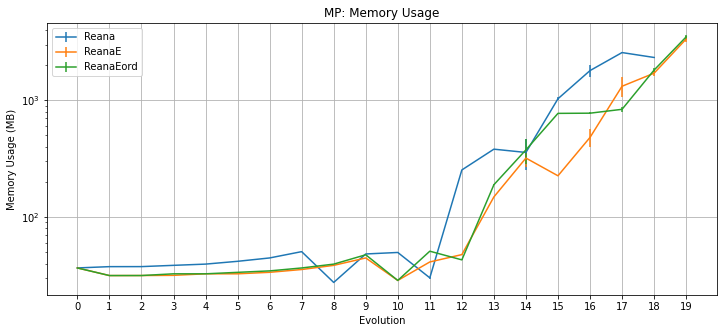

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-22-38f230941c8c>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
<ipython-input-22-38f230941c8c>:11: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


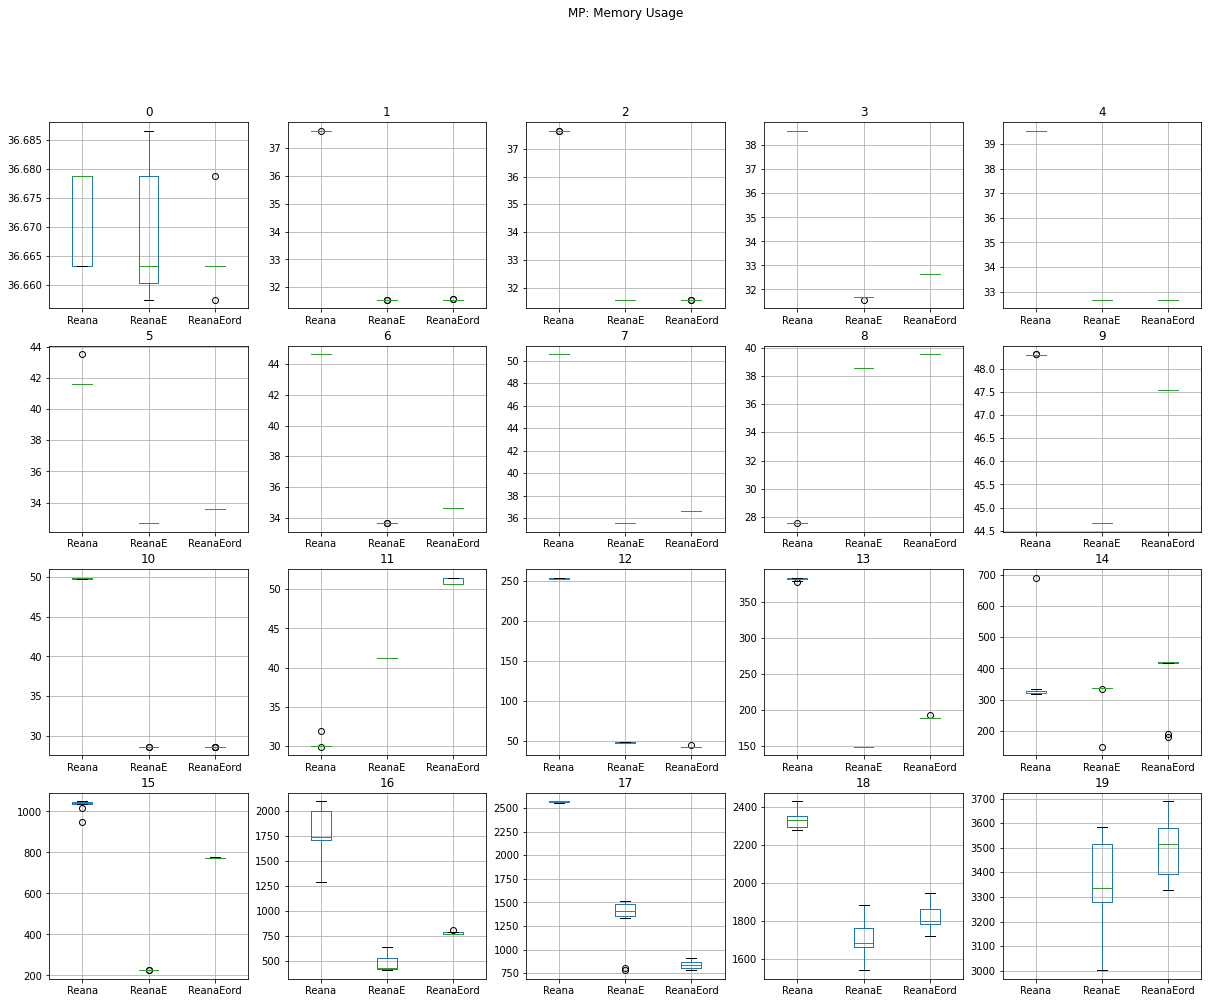

Average memory usage (MB) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'eq', 0.36129258154299226),
   ('Reana', 'ReanaEord', 'gt', 1.5447381374833586),
   ('ReanaE', 'ReanaEord', 'eq', 0.6967099704799887))),
 (1,
  (('Reana', 'ReanaE', 'gt', 1765.9361492886403),
   ('Reana', 'ReanaEord', 'gt', 1673.218210327902),
   ('ReanaE', 'ReanaEord', 'lt', -1.5118102056332223))),
 (2,
  (('Reana', 'ReanaE', 'gt', 1892.990357737802),
   ('Reana', 'ReanaEord', 'gt', 1633.741970967668),
   ('ReanaE', 'ReanaEord', 'eq', 0.7602110806291947))),
 (3,
  (('Reana', 'ReanaE', 'gt', 286.19086724169966),
   ('Reana', 'ReanaEord', 'gt', 1291.549974798929),
   ('ReanaE', 'ReanaEord', 'lt', -41.08014320890251))),
 (4,
  (('Reana', 'ReanaE', 'gt', inf),
   ('Reana', 'ReanaEord', 'gt', inf),
   ('ReanaE', 'ReanaEord', 'eq', nan))),
 (5,
  (('Reana', 'ReanaE', 'gt', 26.981330741834157),
   ('Reana', 'ReanaEord', 'gt', 24.145537921450593),
   ('ReanaE', 'ReanaEord', 'lt', -inf))),
 (6,
  (('Reana', 'ReanaE', 'gt', 3448.995614604408),
   ('Reana', 'ReanaEord

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 36.67 | 37.62 | 37.64 | 38.60 | 39.55 | 41.79 | 44.66 | 50.58 | **27.54** | 48.30 |
| ReanaE | 36.67 | **31.55** | 31.57 | **31.68** | 32.66 | **32.66** | **33.64** | **35.55** | 38.58 | **44.66** |
| ReanaEord | 36.66 | 31.56 | 31.57 | 32.66 | 32.66 | 33.62 | 34.60 | 36.66 | 39.54 | 47.54 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 49.76 | **30.16** | 253.35 | 381.74 | 357.81 | 1031.98 | 1798.60 | 2566.79 | 2330.42 | -- |
| ReanaE | 28.66 | 41.26 | 47.70 | **148.86** | **320.29** | **225.84** | **481.38** | 1320.69 | 1708.61 | 3348.60 |
| ReanaEord | **28.66** | 51.03 | **43.00** | 189.27 | 376.60 | 773.60 | 776.42 | **838.06** | 1816.79 | 3494.61 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


In [38]:
plot_spl('MP')

# TW

## Running Time

/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


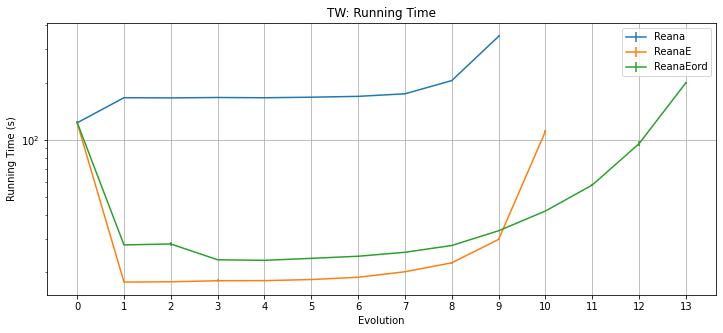

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


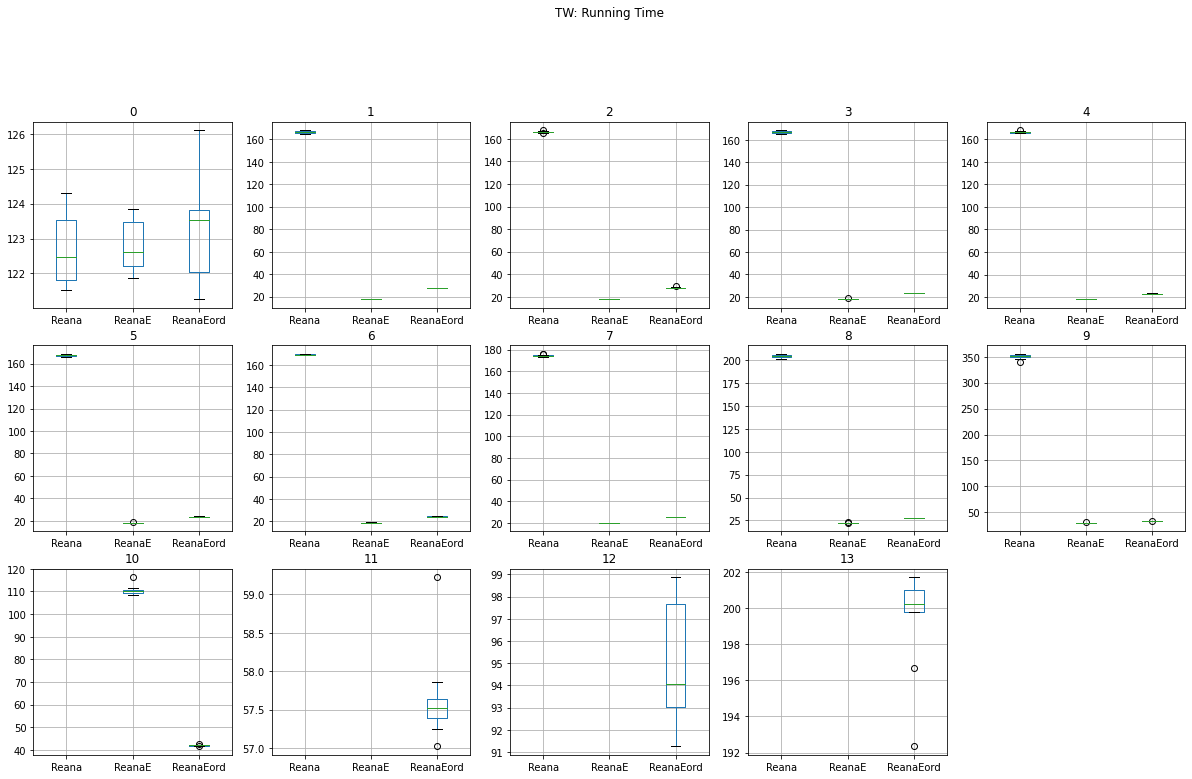

Average running time (s) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'eq', -0.19374153808272154),
   ('Reana', 'ReanaEord', 'eq', -0.5637792037139832),
   ('ReanaE', 'ReanaEord', 'eq', -0.4684238287619918))),
 (1,
  (('Reana', 'ReanaE', 'gt', 248.44713695781005),
   ('Reana', 'ReanaEord', 'gt', 229.6511932889809),
   ('ReanaE', 'ReanaEord', 'lt', -106.32551360280546))),
 (2,
  (('Reana', 'ReanaE', 'gt', 349.7229148159194),
   ('Reana', 'ReanaEord', 'gt', 250.25661185903658),
   ('ReanaE', 'ReanaEord', 'lt', -29.237332215061883))),
 (3,
  (('Reana', 'ReanaE', 'gt', 198.31599547623833),
   ('Reana', 'ReanaEord', 'gt', 198.5486887300644),
   ('ReanaE', 'ReanaEord', 'lt', -21.000886370852246))),
 (4,
  (('Reana', 'ReanaE', 'gt', 335.6821990940262),
   ('Reana', 'ReanaEord', 'gt', 317.01076613588424),
   ('ReanaE', 'ReanaEord', 'lt', -44.27645168377412))),
 (5,
  (('Reana', 'ReanaE', 'gt', 275.7727342711895),
   ('Reana', 'ReanaEord', 'gt', 262.4344996727938),
   ('ReanaE', 'ReanaEord', 'lt', -39.41246464730133))),
 (6,
  (('Reana

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 122.71 | 166.44 | 166.03 | 166.88 | 166.38 | 167.47 | 169.20 | 174.49 | 204.92 | 350.56 |
| ReanaE | 122.85 | **17.75** | **17.81** | **18.03** | **18.06** | **18.30** | **18.81** | **20.11** | **22.42** | **29.78** |
| ReanaEord | 123.34 | 27.87 | 28.18 | 23.26 | 23.11 | 23.67 | 24.28 | 25.48 | 27.67 | 33.08 |
| --- | 10 | 11 | 12 | 13 | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 110.54 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | **42.04** | 57.64 | 95.25 | 199.53 | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/breno/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


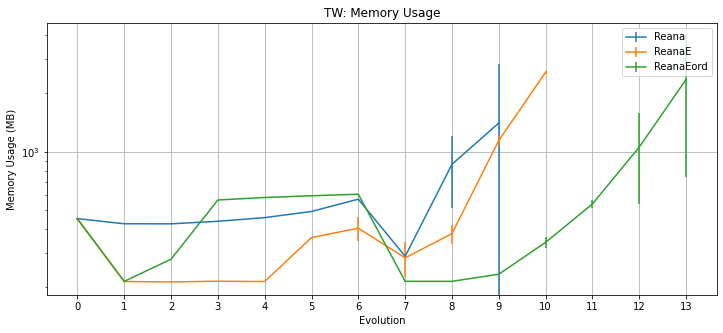

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


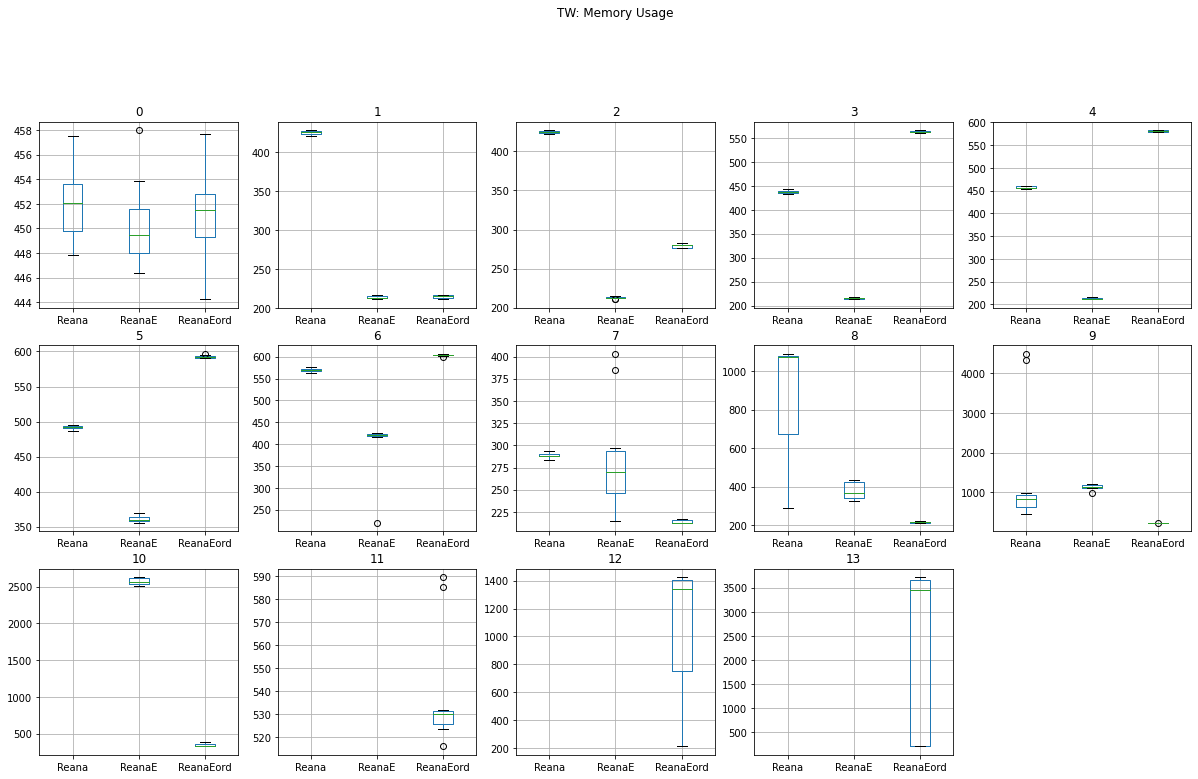

Average memory usage (MB) (statistically smallest value in bold)

[(0,
  (('Reana', 'ReanaE', 'eq', 0.6306980639802523),
   ('Reana', 'ReanaEord', 'eq', 0.2755465650464107),
   ('ReanaE', 'ReanaEord', 'eq', -0.32503759890066763))),
 (1,
  (('Reana', 'ReanaE', 'gt', 111.41241858839982),
   ('Reana', 'ReanaEord', 'gt', 111.62284935596638),
   ('ReanaE', 'ReanaEord', 'eq', -0.21188783634568603))),
 (2,
  (('Reana', 'ReanaE', 'gt', 161.9394541322936),
   ('Reana', 'ReanaEord', 'gt', 84.24232544694372),
   ('ReanaE', 'ReanaEord', 'lt', -41.17332100103974))),
 (3,
  (('Reana', 'ReanaE', 'gt', 96.2623320394064),
   ('Reana', 'ReanaEord', 'lt', -53.58690463161077),
   ('ReanaE', 'ReanaEord', 'lt', -223.55096780159184))),
 (4,
  (('Reana', 'ReanaE', 'gt', 151.66607573837763),
   ('Reana', 'ReanaEord', 'lt', -77.22168733976834),
   ('ReanaE', 'ReanaEord', 'lt', -245.94903757398538))),
 (5,
  (('Reana', 'ReanaE', 'gt', 41.20317543724801),
   ('Reana', 'ReanaEord', 'lt', -51.325922333719554),
   ('ReanaE', 'ReanaEord', 'lt', -78.732452072063))),
 (6,
  (('Reana'

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 451.80 | 424.79 | 424.63 | 437.61 | 457.11 | 491.86 | 569.16 | 288.71 | 861.45 | 1407.51 |
| ReanaE | 450.13 | 213.93 | **212.88** | **214.68** | **213.86** | **360.78** | **403.10** | 283.32 | 378.21 | 1143.57 |
| ReanaEord | 451.08 | 214.27 | 278.89 | 563.55 | 580.60 | 592.57 | 603.69 | **214.40** | **214.36** | **233.30** |
| --- | 10 | 11 | 12 | 13 | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 2574.06 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEord | **340.79** | 537.84 | 1057.77 | 2362.22 | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


In [39]:
plot_spl('TW')